# Olympics Dataset

In this project, I use different methods to implement Linear Regression on the Olympics dataset. I then proceed to predict the number of medals a country would win using the number of athletes and number of medals won by the country in the previous year.

In [211]:
# import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, accuracy_score

warnings.filterwarnings('ignore')
%matplotlib inline

In [212]:
# read in the data
teams = pd.read_csv("teams.csv")

In [213]:
# view first few rows
teams.head()

,team,year,athletes,events,age,height,weight,prev_medals,medals
0,AFG,1964,8,8,22.0,161.0,64.2,0.0,0
1,AFG,1968,5,5,23.2,170.2,70.0,0.0,0
2,AFG,1972,8,8,29.0,168.3,63.8,0.0,0
3,AFG,1980,11,11,23.6,168.4,63.2,0.0,0
4,AFG,2004,5,5,18.6,170.8,64.8,0.0,0


In [214]:
# check for null values
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014 entries, 0 to 2013
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   team         2014 non-null   object 
 1   year         2014 non-null   int64  
 2   athletes     2014 non-null   int64  
 3   events       2014 non-null   int64  
 4   age          2014 non-null   float64
 5   height       2014 non-null   float64
 6   weight       2014 non-null   float64
 7   prev_medals  2014 non-null   float64
 8   medals       2014 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 141.7+ KB


In [215]:
# statistical summary of the dataset
teams.describe(include='all')

,team,year,athletes,events,age,height,weight,prev_medals,medals
count,2014,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000
unique,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,MEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1995.227408,76.329692,36.877855,24.812612,173.955164,69.328997,10.248759,10.990070
std,NaN,15.227727,129.799427,50.130877,2.758258,5.262469,7.494740,31.951920,33.627528
min,NaN,1964.000000,1.000000,1.000000,17.000000,151.000000,43.300000,0.000000,0.000000
25%,NaN,1984.000000,7.000000,6.000000,23.300000,170.600000,64.700000,0.000000,0.000000
50%,NaN,1996.000000,21.000000,14.000000,24.700000,174.400000,69.500000,0.000000,0.000000
75%,NaN,2008.000000,74.750000,47.000000,26.100000,177.300000,73.400000,4.000000,5.000000


Text(0, 0.5, 'Medals')

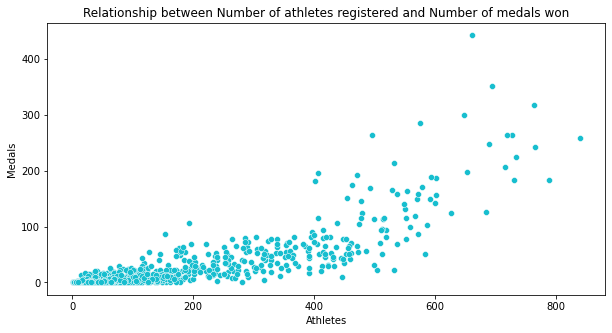

In [216]:
# check for relationship between number of athletes and number of medals
color = sns.color_palette()[9]
plt.figure(figsize=(10, 5))
sns.scatterplot(x='athletes', y='medals', data=teams, color=color)

plt.title('Relationship between Number of athletes registered and Number of medals won')
plt.xlabel('Athletes')
plt.ylabel('Medals')

## Linear Regression by hand

In [217]:
X = teams[["athletes", "prev_medals"]].copy()
y = teams[["medals"]].copy()

In [218]:
X.head()

,athletes,prev_medals
0,8,0.0
1,5,0.0
2,8,0.0
3,11,0.0
4,5,0.0


In [219]:
y.head()

,medals
0,0
1,0
2,0
3,0
4,0


Next, we create a new column for X. This column would contain only 1's and serves as a column constant. This column constant makes it feasible to perform matrix multiplication with the slope and intercept term of the straight line formula.

In [220]:
# create a column of all 1's.
X["intercept"] = 1

In [221]:
X = X[["intercept", "athletes", "prev_medals"]]

In [222]:
X.head()

,intercept,athletes,prev_medals
0,1,8,0.0
1,1,5,0.0
2,1,8,0.0
3,1,11,0.0
4,1,5,0.0


In [223]:
# get the transpose of T
X_T = X.T

In [224]:
X_T

,0,1,2,3,4,5,6,7,8,9,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
intercept,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
athletes,8.0,5.0,8.0,11.0,5.0,4.0,6.0,3.0,4.0,5.0,...,52.0,20.0,47.0,28.0,21.0,26.0,14.0,16.0,9.0,31.0
prev_medals,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,15.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0


Next, we find the slope and intercept terms. These terms are gotten from the formula **y = X * B**. where X * B is the matrix multiplication of both terms, and B is the slope and intercept values. Making B the subject of the formula, we get: **B = (X<sup>T</sup>X)<sup>-1</sup>X<sup>T</sup>y**

In [225]:
B = np.linalg.inv(X_T @ X) @ X_T @ y

In [226]:
B

,medals
0,-1.961889
1,0.071112
2,0.734137


In [227]:
# rename the indexes for B
B.index = X.columns

In [228]:
B

,medals
intercept,-1.961889
athletes,0.071112
prev_medals,0.734137


In [229]:
# now we can predict the values for y (number of medals)
predictions = X @ B

In [230]:
predictions.tail()

,medals
2009,-0.112974
2010,-0.966319
2011,1.378315
2012,1.614667
2013,0.242587


Next, we want to see how accurate we are. To do this we calculate the r<sup>2</sup>. The r<sup>2</sup> represents the proportion of y that is explained by X.

In [231]:
# calculate the Residual sum of squares
SSR = ((y - predictions) ** 2).sum()

In [232]:
SSR

medals    290620.124598
dtype: float64

In [233]:
# next, calculate the total sum of squares
TSS = ((y - y.mean()) ** 2).sum()

In [234]:
TSS

medals    2.276322e+06
dtype: float64

In [235]:
# using the two values gotten above, we calculate the r squared value
R2 = 1 - (SSR / TSS)

In [236]:
R2

medals    0.872329
dtype: float64

We got 0.87 approximately. This means that 87% of the variation in number of medals gotten by a country in a particular year can be explained by the number of athletes that represented that country and the number of medals gotten by that country in the previous year.

## Linear Regression using scikit-learn

In [237]:
# create an instance of the LinearRegression object
lr = LinearRegression()

In [238]:
# fit the model
lr.fit(teams[["athletes", "prev_medals"]], teams[["medals"]])

LinearRegression()

We will now check the intercept and coefficient calculated by the model and compare with the one done by ourselves.

In [239]:
lr.intercept_

array([-1.96188939])

In [240]:
lr.coef_

array([[0.07111214, 0.73413679]])

They are the same. We only computed above what the scikit learn library does automatically.

## Linear Regression using OLS (Ordinary least squares)

In this section, we use another library to perform linear regression. The name of the package is statsmodel.api and there we find a library named OLS. An advantage of this library is the summary function that comes with it . We'll see that later.

We'll first implement with the columns used previously then we'll add more columns and see if it improves the r<sup>2</sup>. 

One thing to note it that unlike Linear Regression in scikit learn, this model requires that you add the constant column, that is, the column of all 1's to the X variable. 

In [241]:
# create model
model = sm.OLS(y, X)

In [242]:
# fit model
results = model.fit()

In [243]:
# create summary report
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 medals   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     6870.
Date:                Fri, 29 Jul 2022   Prob (F-statistic):               0.00
Time:                        22:14:02   Log-Likelihood:                -7864.4
No. Observations:                2014   AIC:                         1.573e+04
Df Residuals:                    2011   BIC:                         1.575e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9619      0.319     -6.153      0.000      -2.587      -1.337
athletes        0.0711      0.004     20.175      0.000       0.064       0.078
prev_medals     0.7341      0.014     51.270      0.000       0.706       0.762
==============================================================================
Omnibus:                     1927.972   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           399976.447
Skew:                           3.949   Prob(JB):                         0.00
Kurtosis:                      71.586   Cond. No.                         182.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-------------------------------------------------------------------------------------------------------------------------------
This is the summary report I talked about earlier. Here, we see the r-squared value at the top and the intercept and slope values near the bottom. There are also other useful summary statistics like p-value and the 95% confidence interval values.

Note that the values gotten before are the same as those shown here.

## Add other variables

In [244]:
teams.head()

,team,year,athletes,events,age,height,weight,prev_medals,medals
0,AFG,1964,8,8,22.0,161.0,64.2,0.0,0
1,AFG,1968,5,5,23.2,170.2,70.0,0.0,0
2,AFG,1972,8,8,29.0,168.3,63.8,0.0,0
3,AFG,1980,11,11,23.6,168.4,63.2,0.0,0
4,AFG,2004,5,5,18.6,170.8,64.8,0.0,0


In [245]:
# create new X with the other independent variables.
X = teams[['athletes', 'age', 'height', 'weight', 'prev_medals']].copy()

In [246]:
# add constant column
X = sm.add_constant(X)

In [247]:
X.head()

,const,athletes,age,height,weight,prev_medals
0,1.0,8,22.0,161.0,64.2,0.0
1,1.0,5,23.2,170.2,70.0,0.0
2,1.0,8,29.0,168.3,63.8,0.0
3,1.0,11,23.6,168.4,63.2,0.0
4,1.0,5,18.6,170.8,64.8,0.0


In [248]:
# create model
model = sm.OLS(y, X)

In [249]:
# fit model
results = model.fit()

In [250]:
# summary report
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 medals   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     2747.
Date:                Fri, 29 Jul 2022   Prob (F-statistic):               0.00
Time:                        22:14:03   Log-Likelihood:                -7863.4
No. Observations:                2014   AIC:                         1.574e+04
Df Residuals:                    2008   BIC:                         1.577e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.5916     10.410      0.921      0.357     -10.823      30.007
athletes        0.0716      0.004     20.105      0.000       0.065       0.079
age            -0.1080      0.100     -1.085      0.278      -0.303       0.087
height         -0.0627      0.071     -0.884      0.377      -0.202       0.076
weight          0.0290      0.050      0.584      0.560      -0.068       0.126
prev_medals     0.7338      0.014     51.202      0.000       0.706       0.762
==============================================================================
Omnibus:                     1924.434   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           398606.892
Skew:                           3.937   Prob(JB):                         0.00
Kurtosis:                      71.469   Cond. No.                     8.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-------------------------------------------------------------------------------------------------------------------------------

The r-squared values did not change after adding those extra columns. Looking at the p-values for these columns, we see that they are pretty high compared to the two columns we used before. This means that these extra columns does not significantly affect the outcome y.

-------------------------------------------------------------------------------------------------------------------------------

## Predicting outcomes (Number of medals)

Here, we'll use scikit learn's Linear Regression to predict the number of medals won by a country using the number of athletes registered and the number of medals won in the previous year.

We will not use the other variables because as seen in the summary report above, these variables do not signifivantly affect the target variable (y).

In [251]:
teams.head()

,team,year,athletes,events,age,height,weight,prev_medals,medals
0,AFG,1964,8,8,22.0,161.0,64.2,0.0,0
1,AFG,1968,5,5,23.2,170.2,70.0,0.0,0
2,AFG,1972,8,8,29.0,168.3,63.8,0.0,0
3,AFG,1980,11,11,23.6,168.4,63.2,0.0,0
4,AFG,2004,5,5,18.6,170.8,64.8,0.0,0


First we split the data into train and test sets. We'll not use sklearn model selection's train_test_split because we do not want future years in the train data and past years in the test data. 

We split by putting years before 2012 in the train data and years after 2012 in the test data.

In [252]:
train = teams[teams['year'] < 2012]
test = teams[teams['year'] >= 2012]

About an 80-20 split

In [253]:
train.shape

(1609, 9)

In [254]:
test.shape

(405, 9)

In [255]:
predictors = ['athletes', 'prev_medals']

In [256]:
# create regression model
reg = LinearRegression()

In [257]:
# fit regression model
reg.fit(train[predictors], train['medals'])

LinearRegression()

In [258]:
# make predictions
result = reg.predict(test[predictors])

In [259]:
# should be a column of values
result.shape

(405,)

In [260]:
# add predictions to the test dataframe in order to be able to calculate accuracy
test['predictions'] = result

In [261]:
test.head()

,team,year,athletes,events,age,height,weight,prev_medals,medals,predictions
6,AFG,2012,6,6,24.8,171.7,60.8,1.0,1,-0.961221
7,AFG,2016,3,3,24.7,173.7,74.0,1.0,0,-1.176333
23,ALB,2012,10,9,25.7,176.8,80.2,0.0,0,-1.425032
24,ALB,2016,6,6,23.7,176.2,67.2,0.0,0,-1.711847
35,ALG,2012,39,29,24.8,174.3,66.9,2.0,1,2.155629


We can see that there are negative values for predictions. This should not be possible so we would change all negative values to zero.

In [262]:
test.loc[test["predictions"] < 0, "predictions"] = 0

In [263]:
test.head()

,team,year,athletes,events,age,height,weight,prev_medals,medals,predictions
6,AFG,2012,6,6,24.8,171.7,60.8,1.0,1,0.000000
7,AFG,2016,3,3,24.7,173.7,74.0,1.0,0,0.000000
23,ALB,2012,10,9,25.7,176.8,80.2,0.0,0,0.000000
24,ALB,2016,6,6,23.7,176.2,67.2,0.0,0,0.000000
35,ALG,2012,39,29,24.8,174.3,66.9,2.0,1,2.155629


Let's round up the numbers to whole numbers

In [264]:
test["predictions"] = test["predictions"].round().astype('int')

In [265]:
test.head()

,team,year,athletes,events,age,height,weight,prev_medals,medals,predictions
6,AFG,2012,6,6,24.8,171.7,60.8,1.0,1,0
7,AFG,2016,3,3,24.7,173.7,74.0,1.0,0,0
23,ALB,2012,10,9,25.7,176.8,80.2,0.0,0,0
24,ALB,2016,6,6,23.7,176.2,67.2,0.0,0,0
35,ALG,2012,39,29,24.8,174.3,66.9,2.0,1,2


Now, we calculate the error using MAE and MSE, and also the accuracy using accuracy_score

In [266]:
# mean absolute error
mae = MAE(test['medals'], test['predictions'])
mae

3.2987654320987656

In [267]:
# mean squared error
mse = MSE(test['medals'], test['predictions'])
mse

65.42222222222222

In [268]:
# accuracy
acc = accuracy_score(test['medals'], test['predictions'])
acc

0.5654320987654321

The model is correct just above 50% of the time. A mean absolute error of 3.3 indicates that on average, we were within 3.3 medals of how many medals the team actually won.

## Transforming Variables

Sometimes performing transformations on the predictor or target variable might make the linear model predict better. Here, we'll try to transform one of the variables and see if we can improve on the accuracy.

In [269]:
# transform the target variable by taking the square root
teams['medals_transform'] = teams['medals'] ** 0.5

In [270]:
teams.head()

,team,year,athletes,events,age,height,weight,prev_medals,medals,medals_transform
0,AFG,1964,8,8,22.0,161.0,64.2,0.0,0,0.0
1,AFG,1968,5,5,23.2,170.2,70.0,0.0,0,0.0
2,AFG,1972,8,8,29.0,168.3,63.8,0.0,0,0.0
3,AFG,1980,11,11,23.6,168.4,63.2,0.0,0,0.0
4,AFG,2004,5,5,18.6,170.8,64.8,0.0,0,0.0


<AxesSubplot:xlabel='athletes', ylabel='medals_transform'>

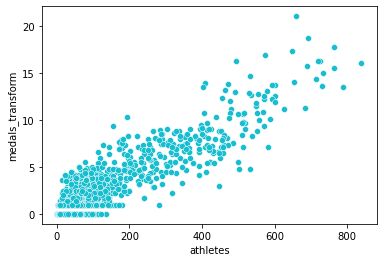

In [271]:
sns.scatterplot(x='athletes', y='medals_transform', data=teams, color=color)

The graph is already looking more linear than earlier. This is a good sign.

In [272]:
train = teams[teams['year'] < 2012]
test = teams[teams['year'] >= 2012]

In [273]:
# fit model with new target variable
reg.fit(train[predictors], train['medals_transform'])

LinearRegression()

In [274]:
# make predictions
result = reg.predict(test[predictors])

In [275]:
# put predictions inside the test dataframe to compare
test['predictions'] = result

In [276]:
test.loc[test["predictions"] < 0, "predictions"] = 0

In [277]:
test["predictions"] = test["predictions"].round().astype('int')

In [278]:
# round medals transform to the nearest whole number and convert to integer
test["medals_transform"] = test["medals_transform"].round().astype('int')

In [279]:
test.head()

,team,year,athletes,events,age,height,weight,prev_medals,medals,medals_transform,predictions
6,AFG,2012,6,6,24.8,171.7,60.8,1.0,1,1,0
7,AFG,2016,3,3,24.7,173.7,74.0,1.0,0,0,0
23,ALB,2012,10,9,25.7,176.8,80.2,0.0,0,0,0
24,ALB,2016,6,6,23.7,176.2,67.2,0.0,0,0,0
35,ALG,2012,39,29,24.8,174.3,66.9,2.0,1,1,1


In [280]:
# mean absolute error
mae = MAE(test['medals_transform'], test['predictions'])
mae

0.5234567901234568

In [281]:
# mean squared error
mse = MSE(test['medals_transform'], test['predictions'])
mse

0.9432098765432099

In [282]:
# accuracy
acc = accuracy_score(test['medals_transform'], test['predictions'])
acc

0.6296296296296297

Nice! Transforming the target variable by taking the square root has increased the accuracy up to approximately 63%. 

The mean absolute error is also down below 1. This is very good as it means that on average we are within approximately 1 medal of how many medals a team actually won.

-------------------------------------------------------------------------------------------------------------------------------